In [5]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

<IPython.core.display.Javascript object>

### 0. Setup

In [7]:
var_names = ["u10", "v10", "t2m", "t850", "z500", "ws10"]
random.seed(7)
# setup:
ran_lat = random.randint(0, 119)
ran_lon = random.randint(0, 129)
ran_forecast_date = random.randint(0, 356)
ran_lead_time = random.randint(0, 30)
lead_times = [1, 15, 30]  # Lead times to plot boxplot with

<IPython.core.display.Javascript object>

### 1. Load Data

In [9]:
# Raw Data:
dat_raw = ldr.load_data_raw()

# # Processese Normed Data
# dat_train_norm = ldp.load_data_all_train_proc_norm()
# dat_test_norm = ldp.load_data_all_test_proc_norm()

# Processese Denormed Data
dat_train_denorm = ldpd.load_data_all_train_proc_denorm()
dat_test_denorm = ldpd.load_data_all_test_proc_denorm()

<IPython.core.display.Javascript object>

### 2. Lead_time - Ensemble_Values

In [5]:
dat_arr_X = []
dat_arr_y = []

for i in range(5):
    dat_arr_X.append(dat_raw[0].predictions.isel(var=i))
    dat_arr_y.append(dat_raw[0].ground_truth.isel(var=i))

# Load means and stds
means = np.load("/mnt/sda/Data2/fourcastnet/data/stats_v0/global_means.npy").flatten()[
    [0, 1, 2, 5, 14]
]
stds = np.load("/mnt/sda/Data2/fourcastnet/data/stats_v0/global_stds.npy").flatten()[
    [0, 1, 2, 5, 14]
]

# Calculate ws10
u10_X = (
    dat_arr_X[0].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon)
    * stds[0]
    + means[0]
)
v10_X = (
    dat_arr_X[1].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon)
    * stds[1]
    + means[1]
)
u10_y = (
    dat_arr_y[0].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon)
    * stds[0]
    + means[0]
)
v10_y = (
    dat_arr_y[1].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon)
    * stds[1]
    + means[1]
)

ws10_X = np.sqrt(u10_X ** 2 + v10_X ** 2)
ws10_y = np.sqrt(u10_y ** 2 + v10_y ** 2)

<IPython.core.display.Javascript object>

/tmp/ipykernel_3340866/4242458414.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks*6)
/tmp/ipykernel_3340866/4242458414.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(current_xticks*6)


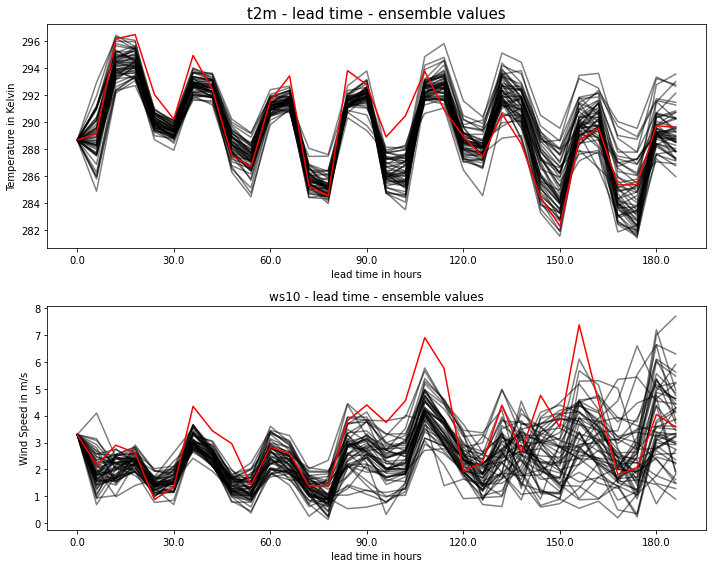

/tmp/ipykernel_3340866/4242458414.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks*6)
/tmp/ipykernel_3340866/4242458414.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks*6)
/tmp/ipykernel_3340866/4242458414.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks*6)
/tmp/ipykernel_3340866/4242458414.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks*6)


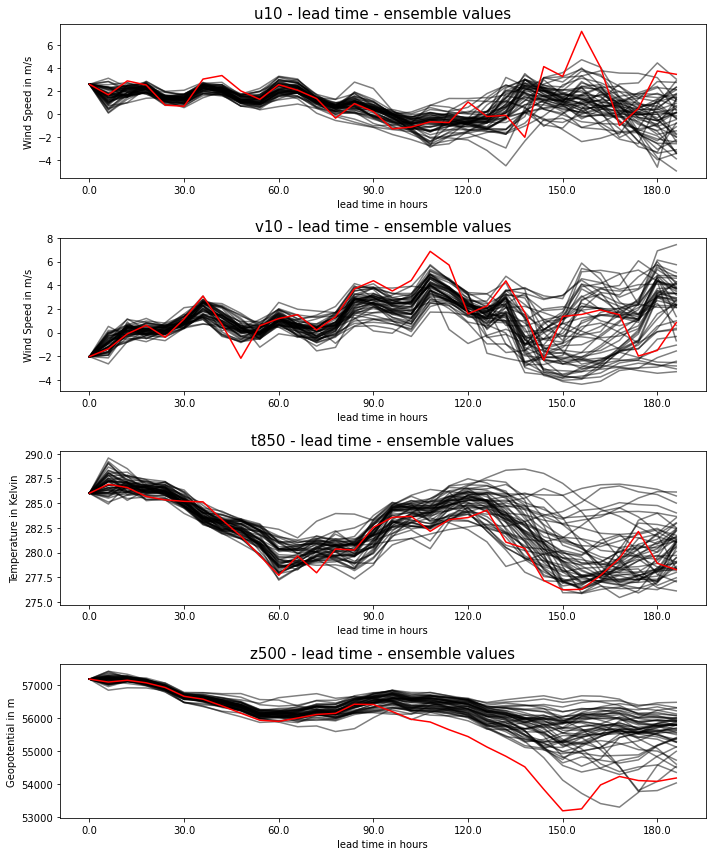

<IPython.core.display.Javascript object>

In [6]:
labels = ['Wind Speed in m/s','Wind Speed in m/s', 'Temperature in Kelvin', 'Temperature in Kelvin', 'Geopotential in m', 'Wind Speed in m/s']
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))

# Plot for the variable in position 2 and ws10
for i, index in enumerate([2]):
    (dat_arr_X[index].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon) * stds[index] + means[index]).plot(
        x="lead_time", hue="ens", add_legend=False, ax=axs[i], color="black", alpha=0.5
    )
    (dat_arr_y[index].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon) * stds[index] + means[index]).plot(
        x="lead_time", ax=axs[i], color="red"
    )
    axs[i].set_title(var_names[index] + " - lead time - ensemble values", size=15)
    axs[i].set_ylabel(labels[index])
    axs[i].set_xlabel('lead time in hours') 
    current_xticks = axs[i].get_xticks()
    axs[i].set_xticklabels(current_xticks*6)

# Plot for ws10
ws10_X.plot(x="lead_time", hue="ens", add_legend=False, ax=axs[1], color="black", alpha=0.5)
ws10_y.plot(x="lead_time", ax=axs[1], color="red")
axs[1].set_title("ws10 - lead time - ensemble values")
axs[1].set_ylabel(labels[5]) 
axs[1].set_xlabel('lead time in hours') 
current_xticks = axs[1].get_xticks()
axs[1].set_xticklabels(current_xticks*6)

plt.tight_layout()
# plt.savefig('/home/dchen/BA_CH_EN/reports/figures/line_plot_lead_hours_value_t2m_ws10.pdf')  # save plot for variables in position 2 and ws10
plt.show()


fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10, 12))

# Plot for the remaining variables, excluding u10 and v10 as they were used to compute ws10
for i, index in enumerate([0, 1, 3, 4]):
    (dat_arr_X[index].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon) * stds[index] + means[index]).plot(
        x="lead_time", hue="ens", add_legend=False, ax=axs[i], color="black", alpha=0.5
    )
    (dat_arr_y[index].isel(forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon) * stds[index] + means[index]).plot(
        x="lead_time", ax=axs[i], color="red"
    )
    axs[i].set_title(var_names[index] + " - lead time - ensemble values", size=15)
    axs[i].set_ylabel(labels[index])
    axs[i].set_xlabel('lead time in hours') 
    current_xticks = axs[i].get_xticks()
    axs[i].set_xticklabels(current_xticks*6)
plt.tight_layout()
# plt.savefig('/home/dchen/BA_CH_EN/reports/figures/line_plot_lead_hours_value_rest.pdf')  # save plot for remaining variables
plt.show()


### 3. Lead_time - Ens_std

/tmp/ipykernel_3340866/410682455.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks * 6)
/tmp/ipykernel_3340866/410682455.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks * 6)
/tmp/ipykernel_3340866/410682455.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks * 6)
/tmp/ipykernel_3340866/410682455.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks * 6)
/tmp/ipykernel_3340866/410682455.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks * 6)
/tmp/ipykernel_3340866/410682455.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(current_xticks * 6)


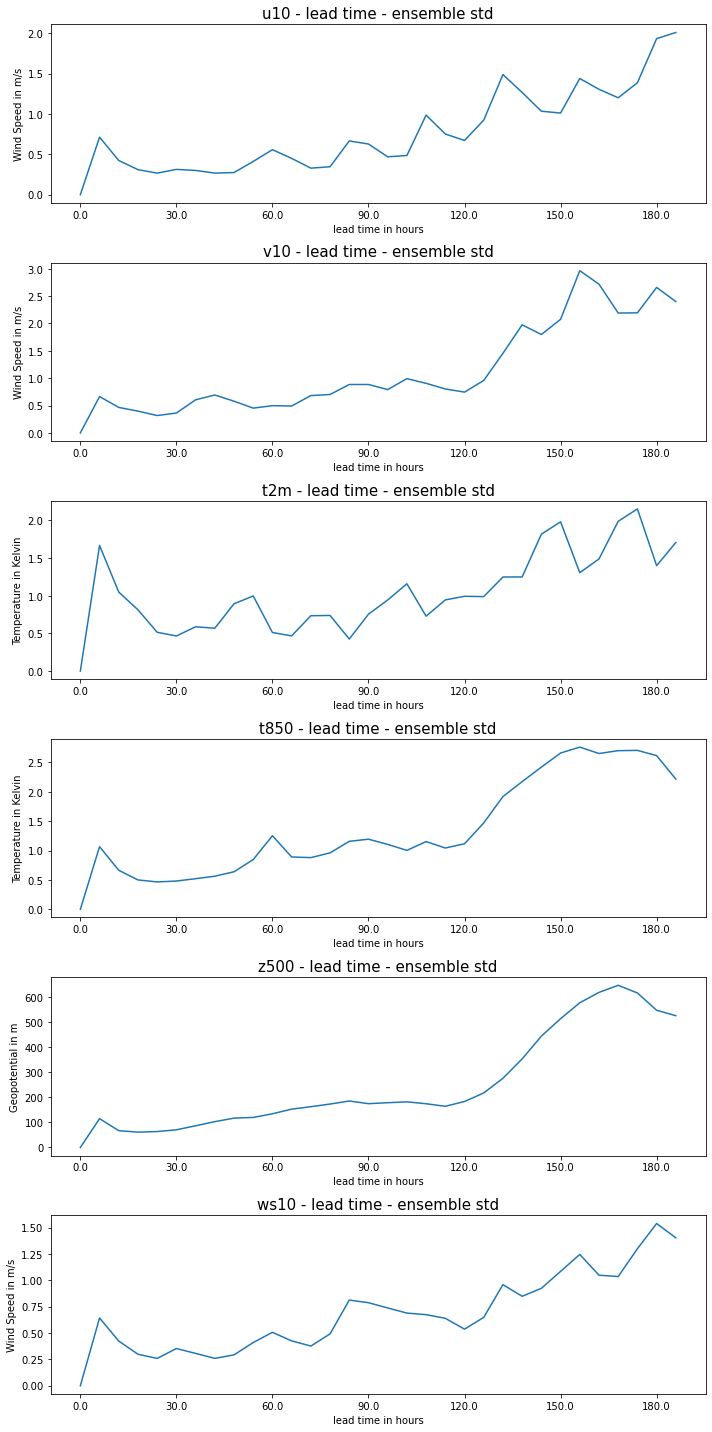

<IPython.core.display.Javascript object>

In [7]:
labels = [
    "Wind Speed in m/s",
    "Wind Speed in m/s",
    "Temperature in Kelvin",
    "Temperature in Kelvin",
    "Geopotential in m",
    "Wind Speed in m/s",
]
fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(10, 20))
for i in range(6):
    dat_train_denorm[i][var_names[i] + "_train"].isel(
        forecast_date=ran_forecast_date, lat=ran_lat, lon=ran_lon, mean_std=1
    ).plot(x="lead_time", ax=axs[i])
    axs[i].set_title(var_names[i] + " - lead time - ensemble std", size=15)
    axs[i].set_ylabel(labels[i])
    axs[i].set_xlabel("lead time in hours")
    current_xticks = axs[i].get_xticks()
    axs[i].set_xticklabels(current_xticks * 6)
plt.tight_layout()
# plt.savefig(
#     "/home/dchen/BA_CH_EN/reports/figures/line_plot_lead_hours_ens-std_all.pdf"
# )  # save plot for remaining variables
plt.show()

### 4. Boxplot denormed mean and std

#### 4.1 T2m

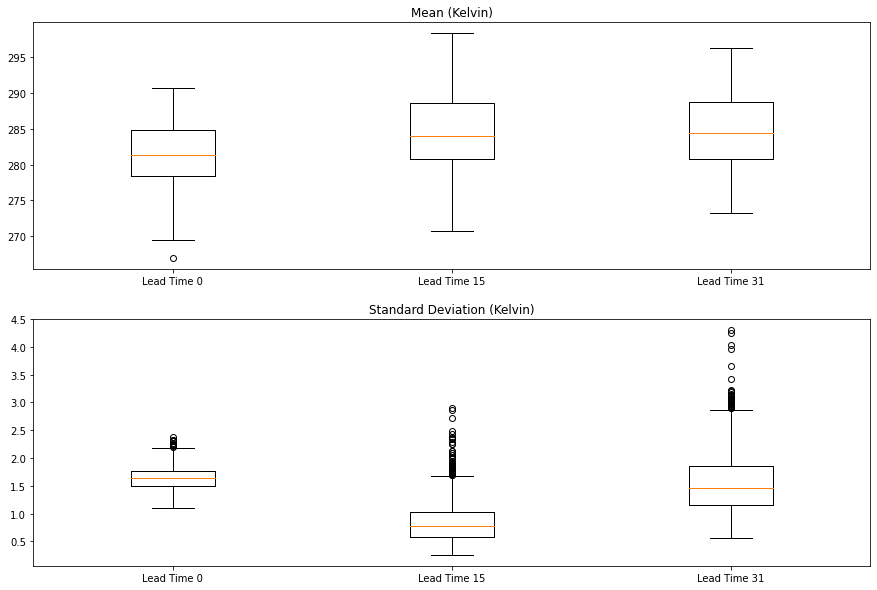

<IPython.core.display.Javascript object>

In [8]:
dat_train_denorm_t2m = dat_train_denorm[2]
# The values of the mean and stds
means_t2m = dat_train_denorm_t2m.t2m_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=0
)
stds_t2m = dat_train_denorm_t2m.t2m_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=1
)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Create an empty lists to store the data for each boxplot
boxplot_means = []
boxplot_stds = []

# Fill the list with data
for i in range(3):
    boxplot_means.append(means_t2m.isel(lead_time=i))
    boxplot_stds.append(stds_t2m.isel(lead_time=i))

# Create boxplots from the data list
axs[0].boxplot(boxplot_means)
axs[1].boxplot(boxplot_stds)

# Add x-axis labels if necessary
axs[0].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[0].set_title("Mean (Kelvin)")

axs[1].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[1].set_title("Standard Deviation (Kelvin)")

plt.show()

#### 4.2 WS10 

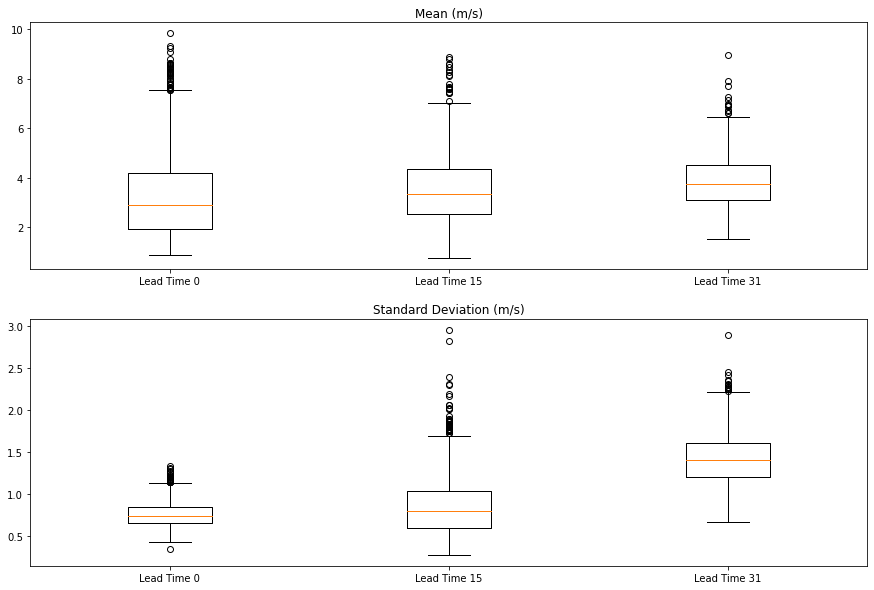

<IPython.core.display.Javascript object>

In [9]:
dat_train_denorm_ws10 = dat_train_denorm[5]
# The values of the mean and stds
means_ws10 = dat_train_denorm_ws10.ws10_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=0
)
stds_ws10 = dat_train_denorm_ws10.ws10_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=1
)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Create an empty lists to store the data for each boxplot
boxplot_means = []
boxplot_stds = []

# Fill the list with data
for i in range(3):
    boxplot_means.append(means_ws10.isel(lead_time=i))
    boxplot_stds.append(stds_ws10.isel(lead_time=i))

# Create boxplots from the data list
axs[0].boxplot(boxplot_means)
axs[1].boxplot(boxplot_stds)

# Add x-axis labels if necessary
axs[0].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[0].set_title("Mean (m/s)")

axs[1].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[1].set_title("Standard Deviation (m/s)")

plt.show()

### 5. Heatmaps

#### 5.1 Mean

In [27]:
lead_time_real = 29
lead_time_hours = "174h"
days_back = 7

t2m_preds = dat_test_denorm[2].t2m_test.isel(
    lead_time=lead_time_real, mean_std=0, forecast_date=ran_forecast_date - days_back,
)
t2m_truth = dat_test_denorm[2].t2m_test_truth.isel(
    lead_time=lead_time_real, forecast_date=ran_forecast_date - days_back
)
ws10_preds = dat_test_denorm[5].ws10_test.isel(
    lead_time=lead_time_real, mean_std=0, forecast_date=ran_forecast_date - days_back,
)
ws10_truth = dat_test_denorm[5].ws10_test_truth.isel(
    lead_time=lead_time_real, forecast_date=ran_forecast_date - days_back
)

<IPython.core.display.Javascript object>

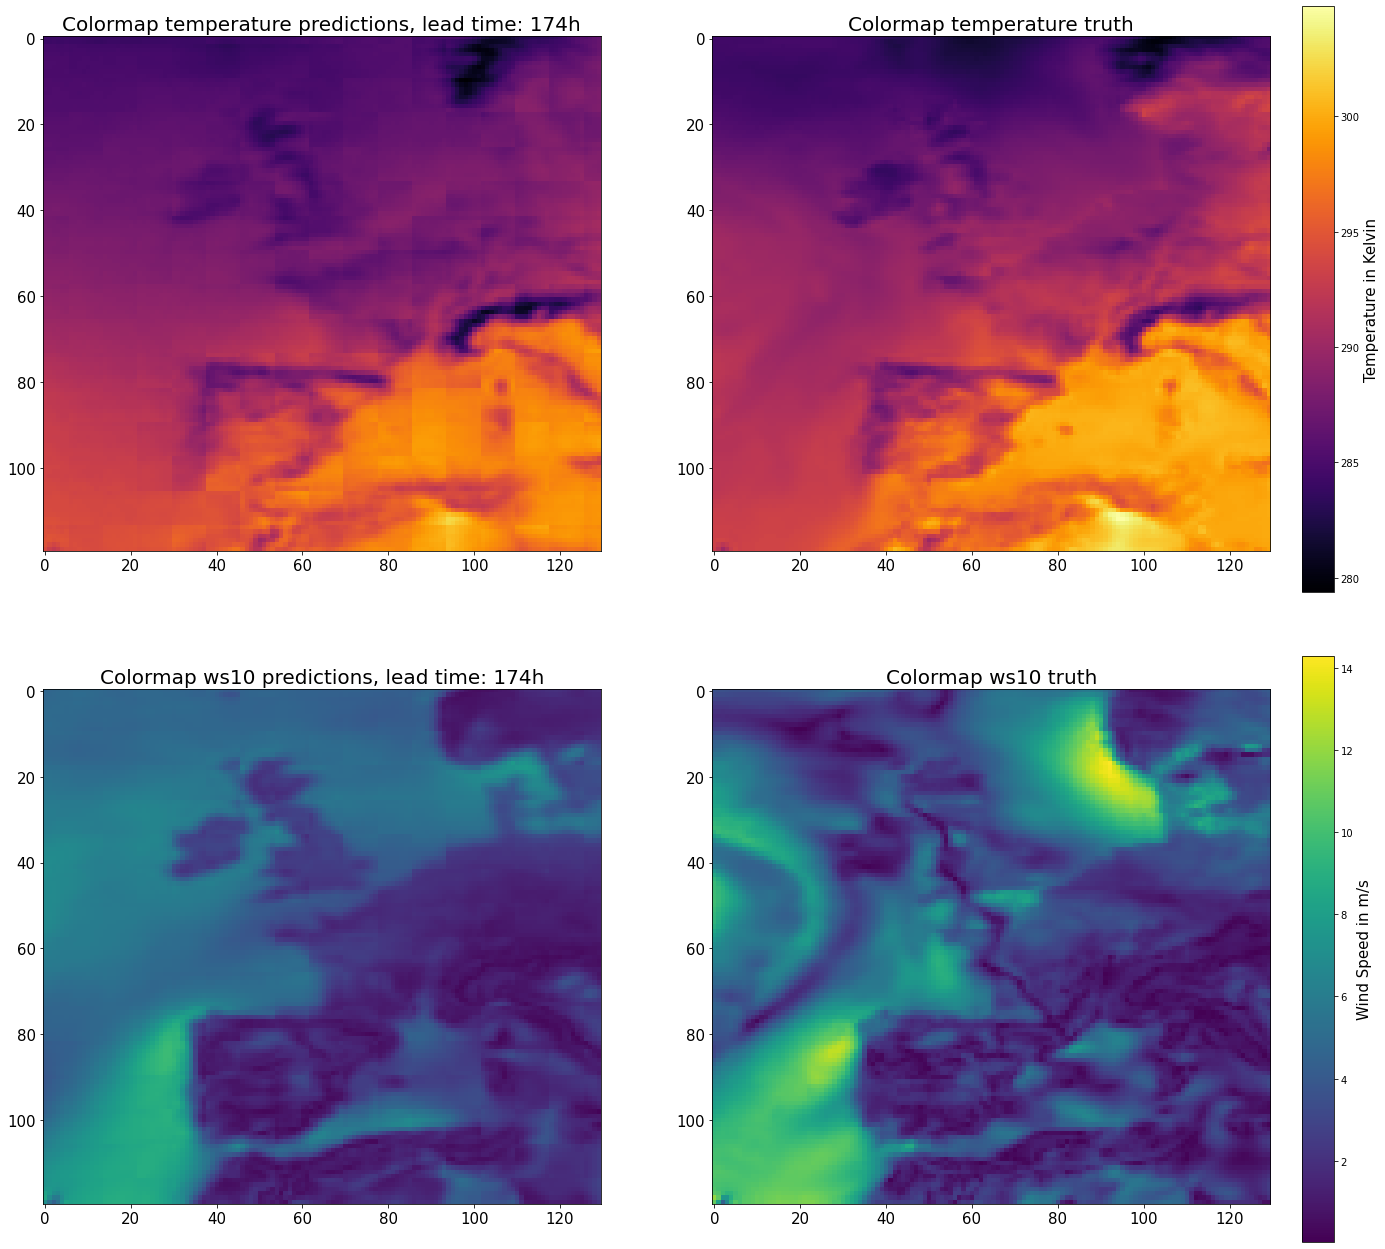

<IPython.core.display.Javascript object>

In [28]:
from matplotlib import cm, colors

fig = plt.figure(figsize=(22, 22))

# Calculate color range for t2m
t2m_min = min(t2m_preds.min(), t2m_truth.min())
t2m_max = max(t2m_preds.max(), t2m_truth.max())

# t2m_preds
ax1 = fig.add_subplot(2, 2, 1)
im1 = ax1.imshow(t2m_preds.values, cmap="inferno", vmin=t2m_min, vmax=t2m_max)
ax1.set_title(
    f"Colormap temperature predictions, lead time: {lead_time_hours}", size=20
)

# t2m_truth
ax2 = fig.add_subplot(2, 2, 2)
im2 = ax2.imshow(t2m_truth.values, cmap="inferno", vmin=t2m_min, vmax=t2m_max)
ax2.set_title("Colormap temperature truth", size=20)

# Colorbar for t2m
cbar_ax_t2m = fig.add_axes(
    [0.92, 0.52, 0.02, 0.37]
)  # You may need to adjust these numbers
norm_t2m = colors.Normalize(vmin=t2m_min, vmax=t2m_max)
cmap_t2m = cm.inferno
mappable_t2m = cm.ScalarMappable(norm=norm_t2m, cmap=cmap_t2m)
cbar_t2m = fig.colorbar(mappable_t2m, cax=cbar_ax_t2m)
cbar_t2m.set_label("Temperature in Kelvin", size=15)

# Calculate color range for ws10
ws10_min = min(ws10_preds.min(), ws10_truth.min())
ws10_max = max(ws10_preds.max(), ws10_truth.max())

# ws10_preds
ax3 = fig.add_subplot(2, 2, 3)
im3 = ax3.imshow(ws10_preds.values, cmap="viridis", vmin=ws10_min, vmax=ws10_max)
ax3.set_title(f"Colormap ws10 predictions, lead time: {lead_time_hours}", size=20)

# ws10_truth
ax4 = fig.add_subplot(2, 2, 4)
im4 = ax4.imshow(ws10_truth.values, cmap="viridis", vmin=ws10_min, vmax=ws10_max)
ax4.set_title("Colormap ws10 truth", size=20)

# Colorbar for ws10
cbar_ax_ws10 = fig.add_axes(
    [0.92, 0.11, 0.02, 0.37]
)  # You may need to adjust these numbers
norm_ws10 = colors.Normalize(vmin=ws10_min, vmax=ws10_max)
cmap_ws10 = cm.viridis
mappable_ws10 = cm.ScalarMappable(norm=norm_ws10, cmap=cmap_ws10)
cbar_ws10 = fig.colorbar(mappable_ws10, cax=cbar_ax_ws10)
cbar_ws10.set_label("Wind Speed in m/s", size=15)

ax1.tick_params(axis="both", which="major", labelsize=15)
ax2.tick_params(axis="both", which="major", labelsize=15)
ax3.tick_params(axis="both", which="major", labelsize=15)
ax4.tick_params(axis="both", which="major", labelsize=15)
plt.savefig(
    f"/home/dchen/BA_CH_EN/reports/figures/heatmap_t2m_ws10_lead_{lead_time_hours}_values.pdf"
)
plt.show()

#### 5.2 Stds

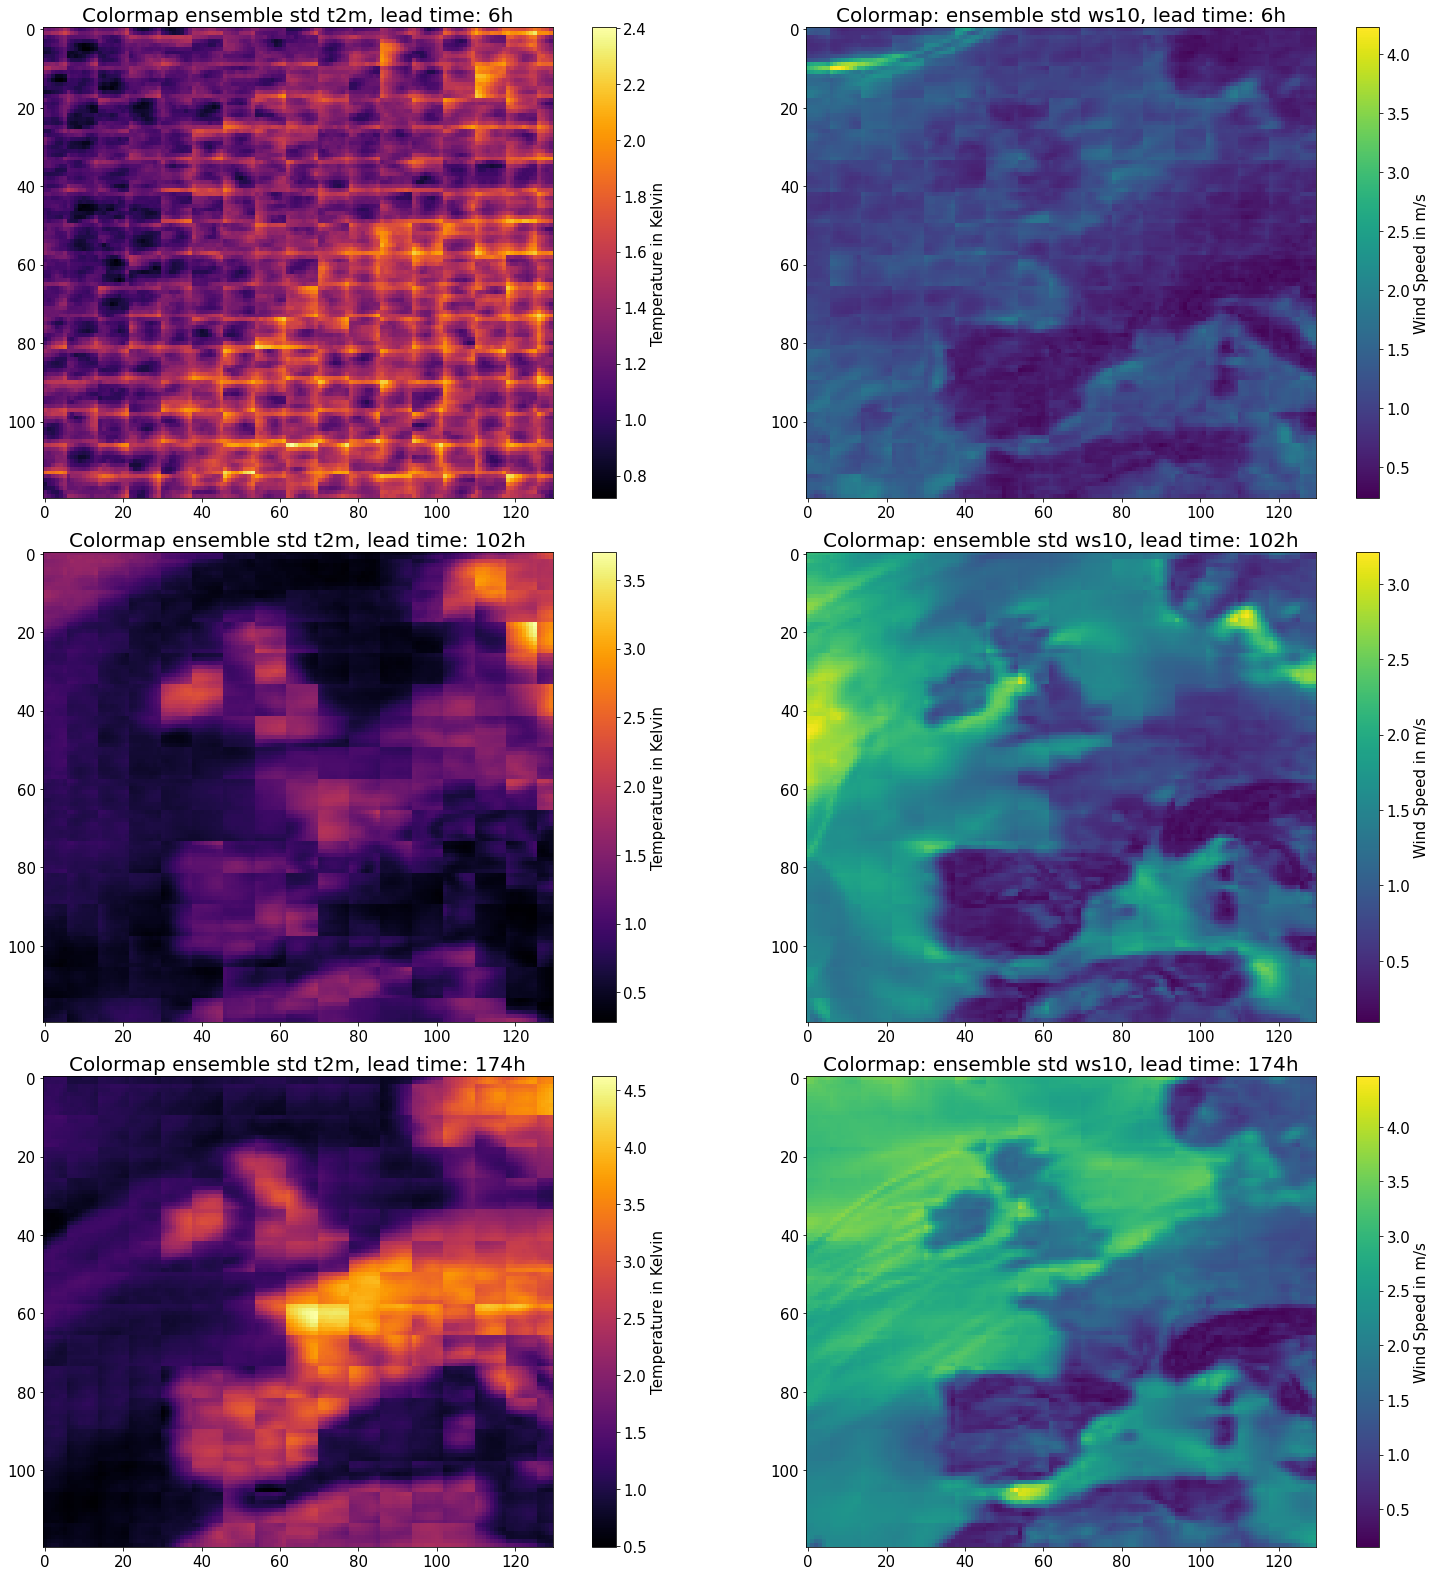

<IPython.core.display.Javascript object>

In [29]:
lead_time_std = [1, 17, 29]
days_back = [0, 4, 7]
lead_time_hours = ["6h", "102h", "174h"]
t2m_std_preds = []
ws10_std_preds = []

for count, lead in enumerate(lead_time_std):
    t2m_std_preds.append(
        dat_test_denorm[2].t2m_test.isel(
            lead_time=lead, mean_std=1, forecast_date=lead - days_back[count],
        )
    )
    ws10_std_preds.append(
        dat_test_denorm[5].ws10_test.isel(
            lead_time=lead, mean_std=1, forecast_date=lead - days_back[count],
        )
    )

fig = plt.figure(figsize=(22, 22))

# Create titles and labels for the two types of predictions
titles = {0: "Colormap ensemble std t2m", 1: "Colormap: ensemble std ws10"}
labels = {0: "Temperature in Kelvin", 1: "Wind Speed in m/s"}
cmaps = {0: "inferno", 1: "viridis"}

# Loop over the three lead times
for j in range(3):
    # Loop over the two types of predictions
    for i, preds in enumerate([t2m_std_preds, ws10_std_preds]):
        ax = fig.add_subplot(3, 2, 2 * j + i + 1)
        im = ax.imshow(preds[j].values, cmap=cmaps[i])
        ax.set_title(f"{titles[i]}, lead time: {lead_time_hours[j]}", size=20)
        cbar = fig.colorbar(im, ax=ax, shrink=1)
        cbar.set_label(labels[i], size=15)
        cbar.ax.tick_params(labelsize=15)
        ax.tick_params(axis="both", which="major", labelsize=15)
plt.tight_layout()
plt.savefig(
    f"/home/dchen/BA_CH_EN/reports/figures/heatmap_t2m_ws10_std_lead_all_values.pdf"
)
plt.show()